In [60]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
print(shap.__version__)

cuda:0
1.8.0a0+52ea372
0.40.0


In [2]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [3]:
model = FashionCNN().to( device )
model.load_state_dict( torch.load("mnist_fashion_CNN.pt") )


<All keys matched successfully>

In [4]:
model.eval()

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [5]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""

train_transform=transforms.Compose([
#         transforms.RandomCrop(28, padding=4),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

batch_size = 1000

trainset = datasets.FashionMNIST('./data', train=True, download=True,
                   transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.FashionMNIST('./data', train=False,
                   transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [6]:
len(trainset)

60000

In [7]:
batch = next(iter(test_loader))
images, labs = batch

In [8]:
images.shape

torch.Size([1000, 1, 28, 28])

In [9]:
background = images[:500]
background = background.to(device, dtype=torch.float)


In [10]:
test_images = images[500:]
test_images = test_images.cpu()
test_images = test_images.numpy()
pants = []
for i in range(len(test_images)):
    tru_lab = int(labs[500+i])
    if tru_lab ==1:
        pants.append(test_images[i])
pants_t = torch.FloatTensor(pants)

In [11]:
e = shap.DeepExplainer(model, background)

In [12]:
shap_values = e.shap_values(pants_t)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [13]:
shap_values = np.asarray(shap_values)
shap_values.shape

(10, 53, 1, 28, 28)

In [15]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
shap_n = np.asarray(shap_numpy)
shap_n.shape

test_numpy = np.swapaxes(np.swapaxes(pants_t.cpu().numpy(), 1, -1), 1, 2)


(10, 53, 28, 28, 1)

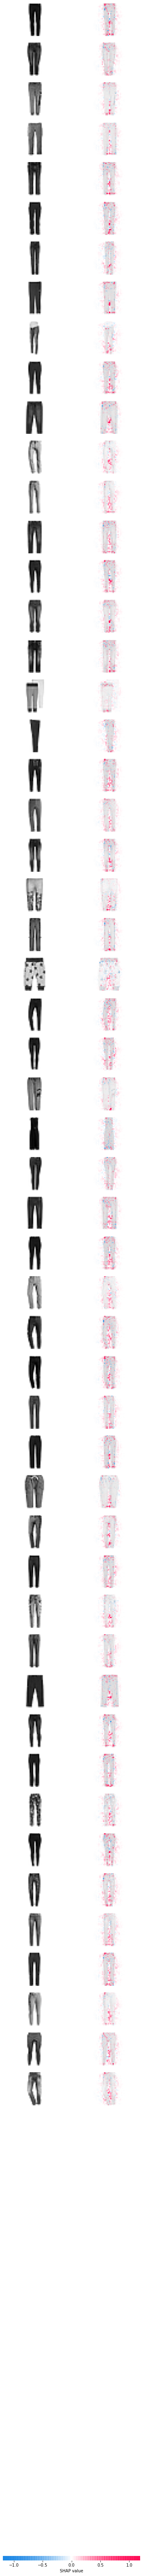

In [17]:
shap.plots.image(shap_numpy[1], -test_numpy, show=False)
plt.savefig('pants_shaps.png')
plt.show()

In [18]:
shap_heatmap = np.zeros((28,28))


In [19]:
pants_shaps = shap_n[1]
pants_shaps.shape

(53, 28, 28, 1)

In [20]:
for i in range(len(pants_shaps)):
    shap_heatmap += pants_shaps[i,:,:,0]

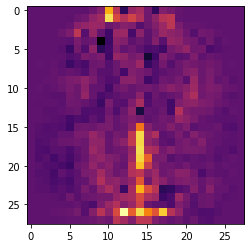

In [21]:
plt.imshow(shap_heatmap, cmap='inferno')
plt.show()

In [22]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [23]:
def smallest_indices(arr, n):
    """Returns the n smallest indices from a numpy array."""
    flat_indices = np.argpartition(arr.ravel(), n-1)[:n]
    row_indices, col_indices = np.unravel_index(flat_indices, arr.shape)
    min_elements = arr[row_indices, col_indices]
    min_elements_order = np.argsort(min_elements)
    row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]
    return row_indices, col_indices

In [24]:
min5idxs = smallest_indices(shap_heatmap, 5)

In [25]:
min5idxs

(array([ 4,  6, 13, 23,  5]), array([ 9, 15, 14, 17,  9]))

In [26]:
top5idxs = largest_indices(shap_heatmap, 5)

In [27]:
top5idxs

(array([26,  1, 18, 26, 16]), array([12, 10, 14, 14, 14]))

In [28]:
for i in range(5):
    print(shap_heatmap[top5idxs[0][i], top5idxs[1][i]])

27.17801981436787
24.151338123716414
23.979850615607575
23.854427190555725
23.636289352783933


In [29]:
for i in range(5):
    print(shap_heatmap[min5idxs[0][i], min5idxs[1][i]])

-10.166697460226715
-6.702325827733148
-5.969316850416362
-4.434746824204922
-4.346568151609972


In [86]:
import random

def perturb_indices(img, arr0, arr1, lo, hi):
    random.seed(123)
    assert(len(arr0) == len(arr1)) 
    img = img.numpy()
    new_img = np.copy(img)
    for i in range(len(arr0)):
        new_img[0,arr0[i], arr1[i]] += random.uniform(lo,hi)
    return new_img
        
    

In [87]:
new_i = perturb_indices(pants_t[0], min5idxs[0], min5idxs[1], 7, 10)

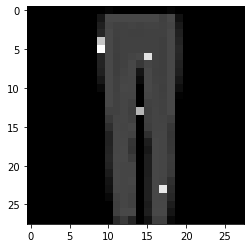

In [88]:
plt.imshow(new_i[0], cmap='gray')
plt.show()

In [89]:
new_i_t = torch.FloatTensor(new_i)
new_i_t = new_i_t.to(device, dtype=torch.float)
new_i_t = new_i_t.unsqueeze(0)

In [90]:
output = model(new_i_t)

In [91]:
outpt = F.softmax(output, dim=1)
print(outpt)
print(torch.argmax(outpt))

tensor([[6.2383e-03, 2.2801e-01, 2.1821e-06, 4.3629e-04, 7.6528e-01, 6.0705e-23,
         2.5257e-05, 3.1548e-22, 1.0526e-15, 7.3249e-17]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor(4, device='cuda:0')


In [92]:
def test_shap_pert(img, arr0, arr1, lo, hi):
    new_i = perturb_indices(img, arr0, arr1, lo, hi)
    new_i_t = torch.FloatTensor(new_i)
    new_i_t = new_i_t.to(device, dtype=torch.float)
    new_i_t = new_i_t.unsqueeze(0)
    
    output = model(new_i_t)
    outpt = F.softmax(output, dim=1)
    predicted_lab = torch.argmax(outpt)
    
    return new_i, outpt, predicted_lab
    

In [101]:
perted_imgs = []
perted_outs = []
pred_labs = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], min5idxs[0], min5idxs[1], 5, 8)
    perted_imgs.append(new_i)
    perted_outs.append(outpt)
    pred_labs.append(predicted_lab)

In [102]:
len(perted_outs)

53

In [103]:
c=0
for l in pred_labs:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,6 ,1 ,1 ,1 ,1 ,1 ,4 ,1 ,1 ,1 ,3 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,3


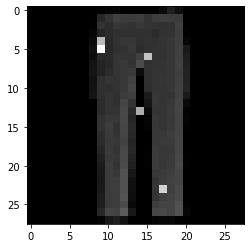

tensor(1, device='cuda:0')


In [104]:
plt.imshow(perted_imgs[3][0],cmap='gray')
plt.show()
print(pred_labs[3])

In [122]:
# trying 10 indexes now
min10idxs = smallest_indices(shap_heatmap, 10)

In [123]:
perted_imgs_10 = []
perted_outs_10 = []
pred_labs_10 = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], min10idxs[0], min10idxs[1], 5, 8)
    perted_imgs_10.append(new_i)
    perted_outs_10.append(outpt)
    pred_labs_10.append(predicted_lab)

In [124]:
c=0
for l in pred_labs_10:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,3 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2


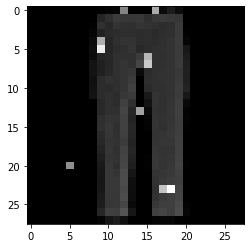

tensor(1, device='cuda:0')


In [125]:
plt.imshow(perted_imgs_10[3][0],cmap='gray')
plt.show()
print(pred_labs_10[3])

In [126]:
# trying 20 indexes now
min20idxs = smallest_indices(shap_heatmap, 20)

In [130]:
perted_imgs_20 = []
perted_outs_20 = []
pred_labs_20 = []

for i in range(len(pants_t)):
    new_i, outpt, predicted_lab = test_shap_pert(pants_t[i], min20idxs[0], min20idxs[1], 5, 8)
    perted_imgs_20.append(new_i)
    perted_outs_20.append(outpt)
    pred_labs_20.append(predicted_lab)

In [131]:
c=0
for l in pred_labs_20:
    print(int(l), ',', end ="")
    if int(l) != 1:
        c+=1
print(c)

0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,1 ,0 ,1 ,1 ,0 ,1 ,1 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0 ,1 ,1 ,1 ,0 ,1 ,0 ,0 ,0 ,1 ,1 ,1 ,1 ,0 ,1 ,0 ,0 ,1 ,1 ,1 ,1 ,0 ,1 ,31


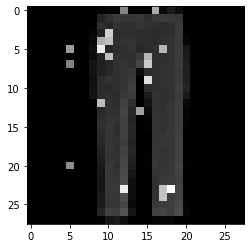

tensor(0, device='cuda:0')
-0.42421296


In [132]:
plt.imshow(perted_imgs_20[3][0],cmap='gray')
plt.show()
print(pred_labs_20[3])
print(perted_imgs[3][0][12][26])